In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def drop_time_fields(session_data):
    """
    Drop the time fields from the session data.
    """

    # drop columns ending with '_time'
    session_data = session_data.drop([col for col in session_data.columns if col.endswith('_time')], axis=1)

    return session_data

def add_trial_in_block(session_data):
    # if already has the property, just return as it is
    if 'trial_id_in_block' in session_data.columns:
        return session_data

    # group by monke, session, block
    for info, subdf in session_data.groupby(['monkey', 'session', 'block_id']):
        # write back to the original dataframe
        session_data.loc[subdf.index, 'trial_id_in_block'] = np.arange(len(subdf))

    # type is int
    session_data['trial_id_in_block'] = session_data['trial_id_in_block'].astype(int)

    return session_data


def show_target_selection(session_data_original, title=None, background_value=None, savedir=None, show=True):
    """
    Generates a figure illustrating the target selection, feedback and target value.

    Parameters
    ----------
    session_data: session data
    Returns
    -------

    """
    # work on a copy of the original data
    session_data = session_data_original.copy()

    # add 'trial in session' column
    session_data = add_trial_in_block(session_data)

    # count blocks
    no_of_blocks = len(session_data['block_id'].unique())

    # init plot
    n_cols = 1
    n_rows = no_of_blocks
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(11, 30))

    # create subplots, block by block
    for i, ax in enumerate(axs.reshape(-1)):
        no_of_trials = len(session_data.loc[session_data['block_id'] == i])  # number of trials in the block

        ### plot selected target and best target
        # get the selected target and its id, for REWARDED trials
        rewarded_trials = session_data.loc[(session_data['block_id'] == i) & (session_data['feedback'] == True)]
        selected_target_rewarded, selected_target_rewarded_id = rewarded_trials['target'], rewarded_trials['trial_id_in_block']

        # get the selected target and its id, for UNREWARDED trials
        unrewarded_trials = session_data.loc[(session_data['block_id'] == i) & (session_data['feedback'] == False)]
        selected_target_unrewarded, selected_target_unrewarded_id = unrewarded_trials['target'], unrewarded_trials['trial_id_in_block']

        # trial ids when the trial was interrupted
        interrupted_trials_id = session_data.loc[(session_data['block_id'] == i) & (session_data['feedback'].isnull()), 'trial_id_in_block']

        ax.scatter(selected_target_rewarded_id, selected_target_rewarded, color='black', marker='o',
                   label='rewarded')  # plot rewarded trials
        ax.scatter(selected_target_unrewarded_id, selected_target_unrewarded, color='black', marker='x',
                   label='unrewarded')  # plot unrewarded trials
        if len(interrupted_trials_id) > 0:
            ax.scatter(interrupted_trials_id, [1 for x in interrupted_trials_id], color='red', marker='s',
                       label='interrupted trial')
            ax.scatter(interrupted_trials_id, [2 for x in interrupted_trials_id], color='red', marker='s')
            ax.scatter(interrupted_trials_id, [3 for x in interrupted_trials_id], color='red', marker='s')

        # plot green lines
        ax.plot(np.arange(0, no_of_trials, 1),
                np.ones((no_of_trials,)) * session_data.loc[session_data['block_id'] == i, 'best_target'],
                label='best target', color='green', alpha=.3, linewidth=20)

        # mark last 5 trials
        ax.vlines(no_of_trials - 6 + 0.5, ymin=0, ymax=30, linestyle='dashed', color='black',
                  label='start of last 5 sessions')

        # plot MEASURE
        if background_value is not None:
            measure_min, measure_max = session_data[background_value].min(), session_data[background_value].max()
            if background_value is not None:
                if background_value in session_data.columns:
                    measure = session_data.loc[
                        (session_data['block_id'] == i), background_value
                    ].to_numpy()
                    ax_ = ax.twinx()
                    ax_.plot(measure, color='tab:red', alpha=.6)
                    if background_value == 'measure':
                        ax_.axhline(0, color='tab:red', linestyle='dashed', alpha=.4)
                    elif background_value == 'reward_rate':
                        ax_.axhline(.5, color='tab:red', linestyle='dashed', alpha=.4)
                    ax_.set_ylabel(background_value, color='tab:red')
                    ax_.set_ylim(measure_min-np.abs(.2*measure_min),
                                measure_max+np.abs(.1*measure_max))
                else:
                    print('background measure not in columns')

        # plot settings
        ax.set_xlabel('trials in block')
        ax.set_ylabel('selected target')
        ax.set_xlim(-0.5, 48)
        ax.set_xticks(range(0, 45, 5))
        ax.set_ylim(0.5, 3.5)
        ax.set_yticks([1, 2, 3])
        ax.title.set_text('block id: ' + str(i))

        spacing = 1  # This can be your user specified spacing.
        from matplotlib.ticker import MultipleLocator
        minor_locator = MultipleLocator(spacing)
        ax.yaxis.set_minor_locator(minor_locator)
        ax.xaxis.set_minor_locator(minor_locator)
        # Set grid to use minor tick locations. grid in the background
        ax.grid(which='both', zorder=-1.0)

        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.4),
                  fancybox=True, shadow=True, ncol=5)

    plt.tight_layout()
    if title is not None:
        plt.suptitle(title, y=1)

    if savedir is not None:
        plt.savefig(savedir)
    if show:
        plt.show()
    else:
        plt.close()


# Load data

In the dataframe, you have all the sessions' behavioral info. Each row represents one trial.

The first two columns identifies a session, with attributes:
- monkey: 'ka' or 'po'
- session: the session number (it is string, not integer!! - some sessions start with 0). Session id codes the time of recording in a form of ddmmyy

The 'trial_id' column is the trial number in the session.

The time fields represent the time of the event in the session (in sec).

The 'block_id' is the block in the session, and 'best target' is the current best target in the block.

'target' is the target that the monkey chose in the trial.

'feedback' is the feedback of the trial, 1 for rewarded and 0 for not rewarded.

Note that some trials have missing information on the time fields and the feeback, its because the monkey did not finish that trial.

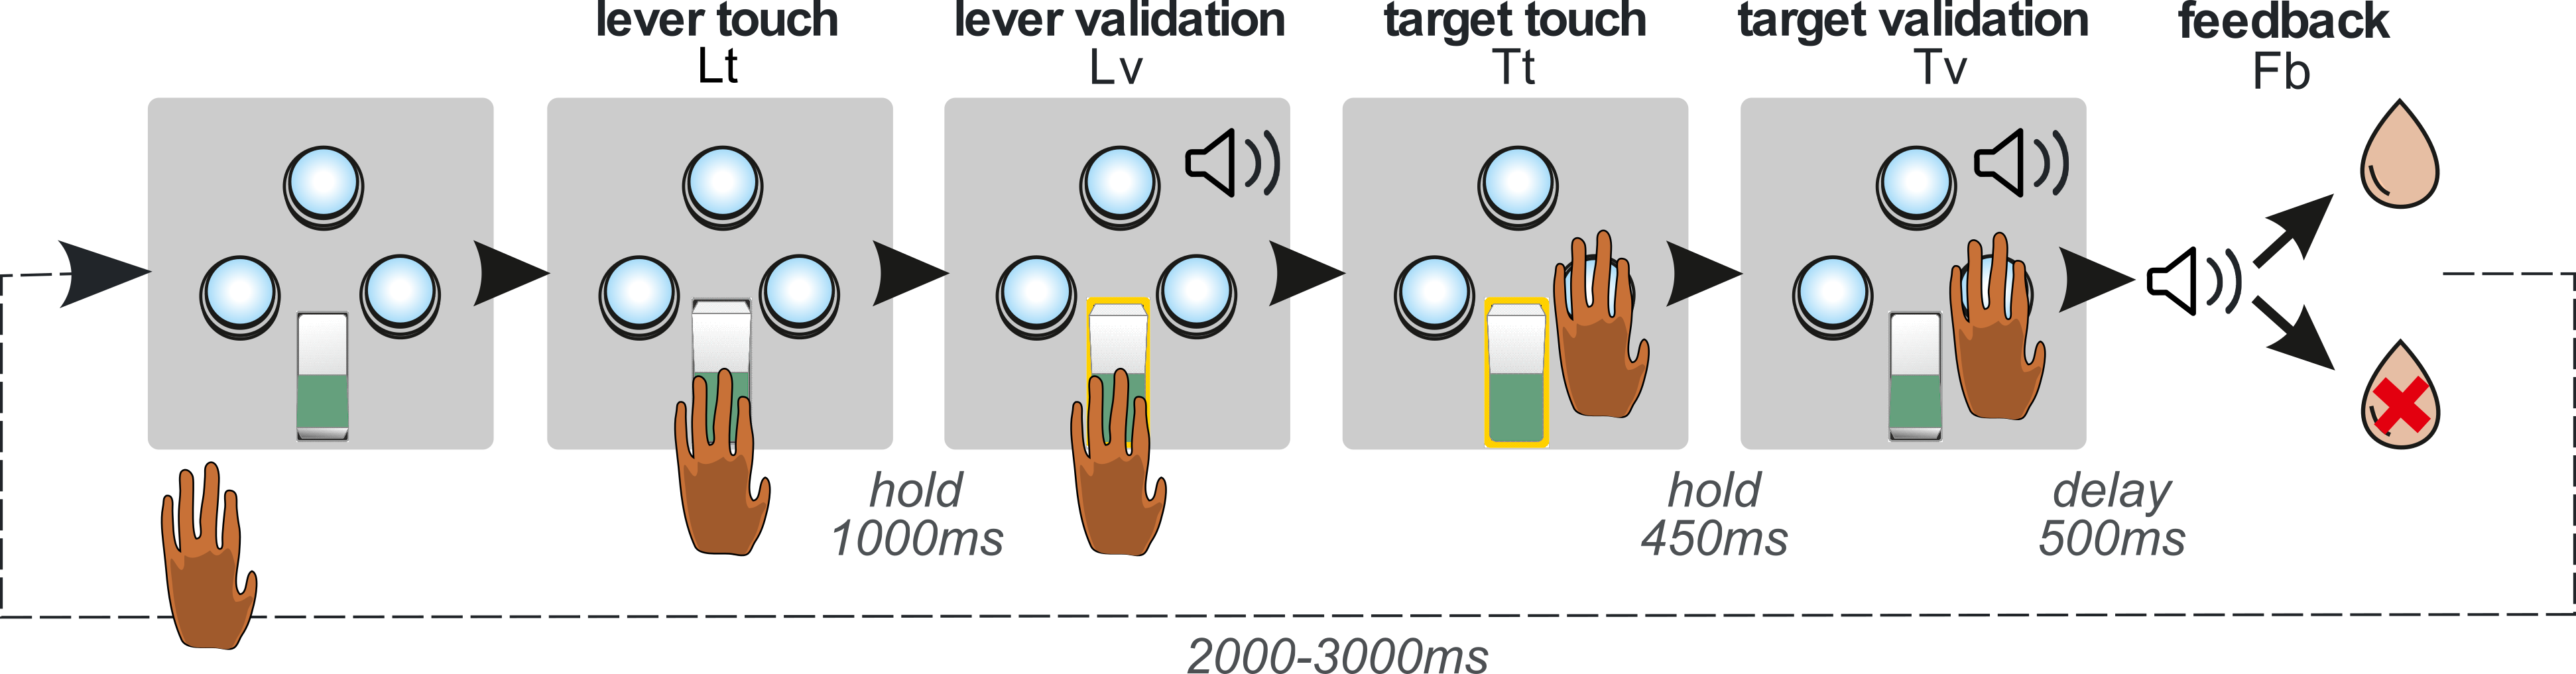

In [2]:
# get data
dataloc = '/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/data/processed/behavior.pkl'
data = pd.read_pickle(dataloc)

data.head()

,monkey,session,trial_id,trial_start_time,lever_touch_time,lever_validation_time,target_touch_time,target_validation_time,feedback_time,trial_end_time,block_id,best_target,target,feedback
0,ka,010720,0,13.3540,17.6059,18.6233,19.7132,20.2440,20.7605,25.3782,0,2,3.0,True
1,ka,010720,1,25.3782,25.9214,26.9376,27.8519,28.3726,28.8874,33.6458,0,2,3.0,False
2,ka,010720,2,33.6458,33.7962,34.8145,35.6236,36.1429,36.6558,40.8605,0,2,1.0,True
3,ka,010720,3,40.8605,41.0857,42.1049,43.4054,43.9535,44.4661,48.5034,0,2,1.0,False
4,ka,010720,4,48.5034,48.5722,49.5969,50.1189,50.6445,51.1576,55.1814,0,2,3.0,True


## Extract one session and plot behavior

In the plot below, the x axis representst the trials, y axis shows the selected target. Each marker indicates the choice of the animal, with 'X' being an unrewarded and 'O' a rewarded choice. The green shading indicates the best target in that block (70% reward rate, other two targets has 25% reward rate, see manuscript attached with the email).

Eaxh plot represents one block. During the last 5 trials of the block, the reward probabilities change gradually (from 70% to 25% or vice versa). The last 5 trials of the block are marked by the dashed line.

Note that a session should be 10-11 blocks long, however often the monkey stopped working before the session end, thus some sessions are shorter.

In [3]:
# behavioral example
monkey, session = 'ka', '210322'

data = drop_time_fields(data)  # remove colums containing times
data = data.loc[(data['monkey'] == monkey) & (data['session'] == session)]  # get one session

data


,monkey,session,trial_id,block_id,best_target,target,feedback
16734,ka,210322,0,0,1,2.0,False
16735,ka,210322,1,0,1,3.0,False
16736,ka,210322,2,0,1,1.0,True
16737,ka,210322,3,0,1,1.0,False
16738,ka,210322,4,0,1,3.0,False
...,...,...,...,...,...,...,...
17154,ka,210322,420,9,3,3.0,True
17155,ka,210322,421,9,3,3.0,False
17156,ka,210322,422,9,3,3.0,False
17157,ka,210322,423,9,3,3.0,False


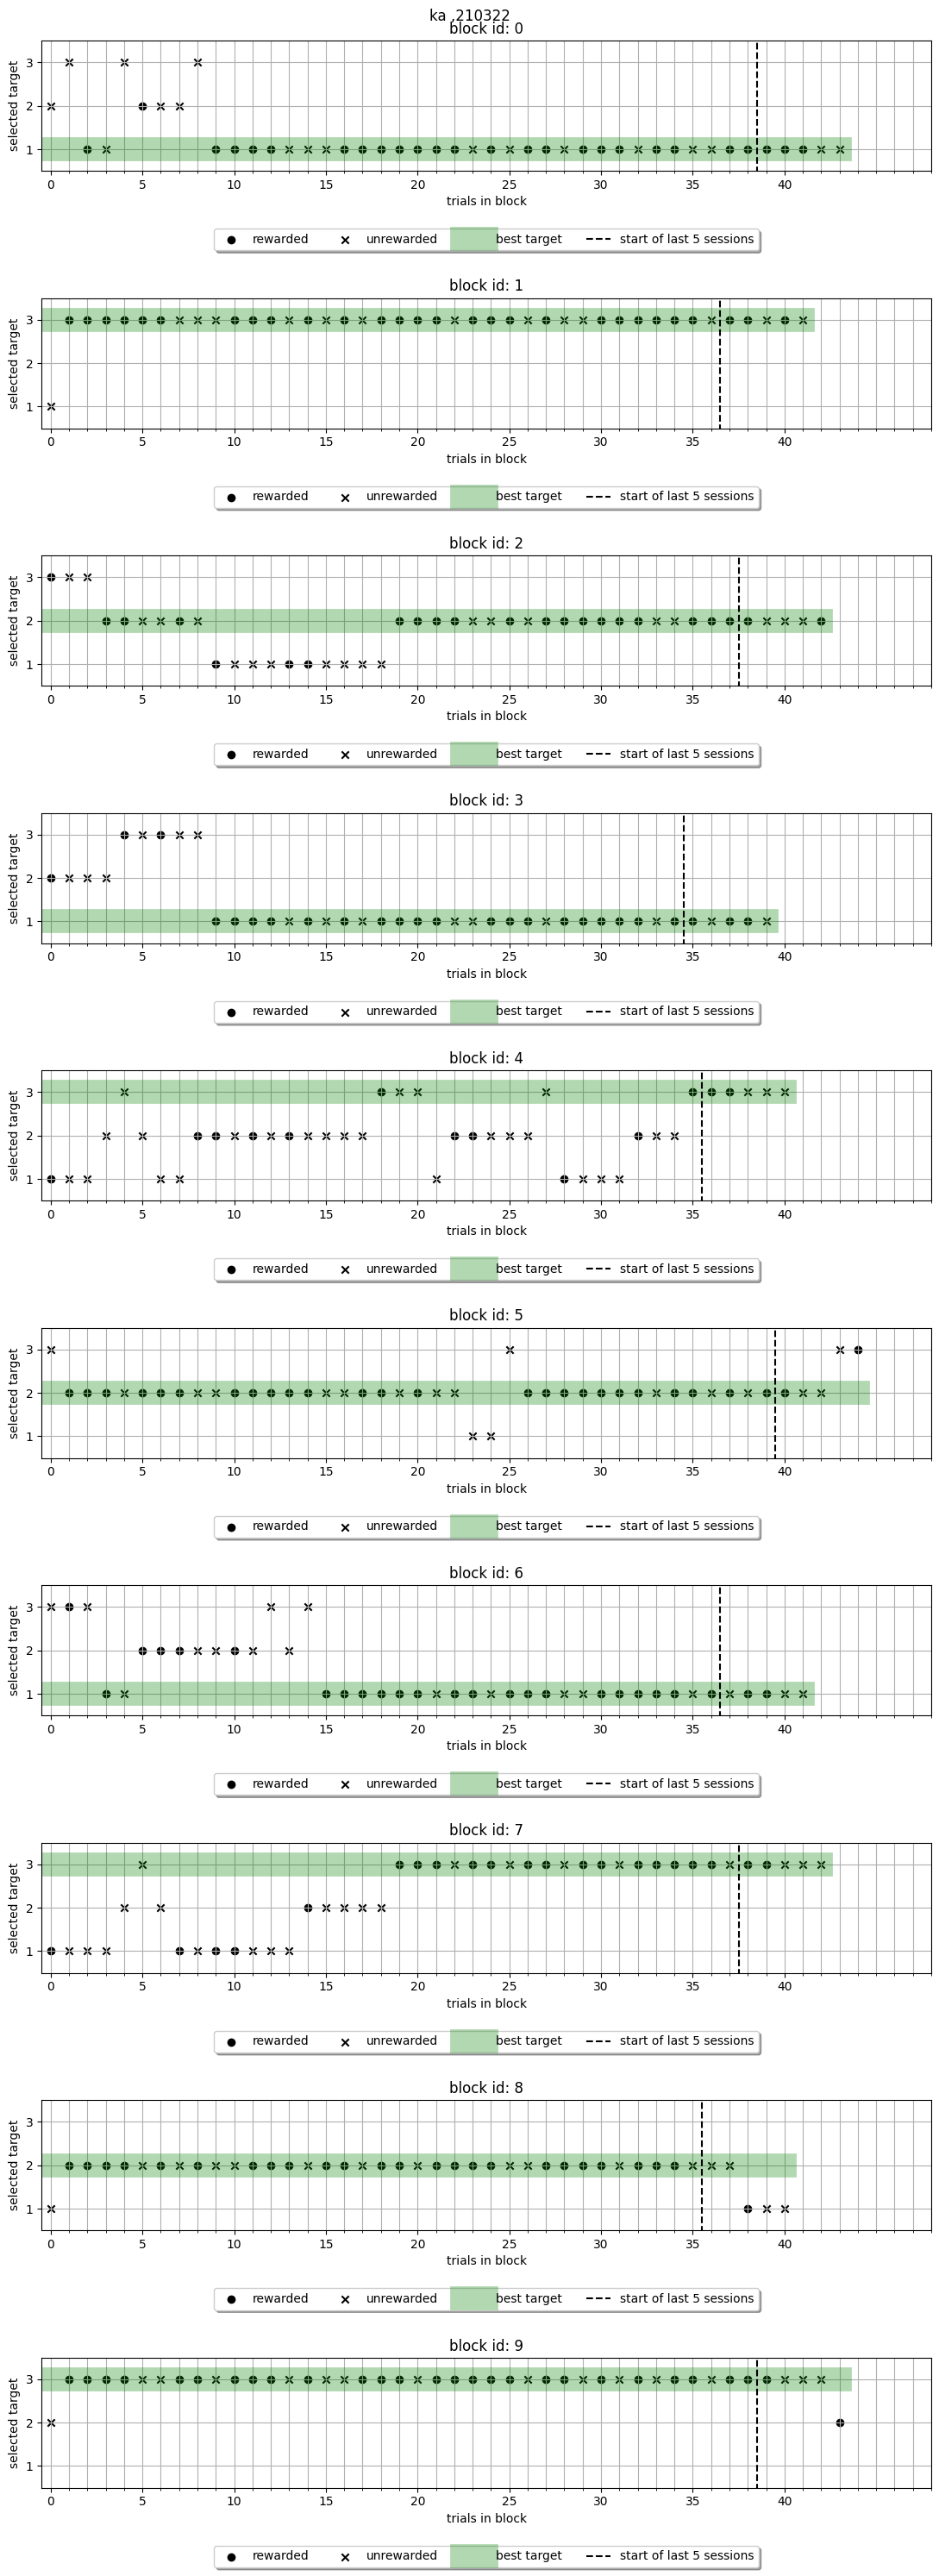

In [4]:
# target selection
show_target_selection(data, title=f'{monkey} ,{session}')